In [1]:
from quspin.basis import spin_basis_general # Hilbert space spin basis
import numpy as np
from Library import Pauli, Model_coefficients, i_trunc, Create_Hamiltonian
from numpy import linalg as LA
import matplotlib.pyplot as plt
from quspin.basis import spin_basis_1d 
from scipy.linalg import expm
import cProfile
import pstats

import numpy as np

data_type=np.complex128
S_z, S_x, S_y, S1 = Pauli()

def Entropy(v):
  return -np.sum(np.log(v)*v)

def Create_Hamiltoniass(Model, S1, Interactions, Fields,d):
    H = np.zeros((d,d,d,d)).astype(np.complex128)

    for j in range(len(Model[0])):
      H += np.einsum("ij,kl->ikjl",Interactions[Model[0][j]]*S1[Model[0][j]],S1[Model[0][j]]) #two-site

    for k in range(len(Model[1])):
      H += np.einsum("ij,kl->ikjl",Fields[Model[1][k]]*S1[Model[1][k]],np.diag(np.ones(2)))    #on-site
      H += np.einsum("ij,kl->ikjl",np.diag(np.ones(2)),Fields[Model[1][k]]*S1[Model[1][k]])
    return H

def Compute_Theta(lam_0,Gamma_0,lam_1,Gamma_1):
    Theta=np.einsum("a,aib->aib",lam_0,Gamma_0)
    Theta=np.einsum("aib,b->aib",Theta,lam_1)
    Theta=np.einsum("aib,bjc->aijc",Theta,Gamma_1)
    Theta=np.einsum("aijc,c->aijc",Theta,lam_0)

    return Theta

def apply_two_site_unitary(lam_0,Gamma_0,lam_1,Gamma_1,U,chi,d):
    Theta = Compute_Theta(lam_0,Gamma_0,lam_1,Gamma_1)

    Theta=np.einsum("ijkl,aijb->aklb",U,Theta)
    Theta=Theta.reshape(chi*d,chi*d)         

    Sigma,lam_1,Ve=i_trunc(chi,Theta)

    vi=np.divide(1.0, lam_0, out=np.zeros_like(lam_0), where=np.abs(lam_0)>=1E-14)
    Gamma_1=np.einsum("aib,b->aib",Ve,vi)                            
    Gamma_0=np.einsum("a,aib->aib",vi,Sigma) 
    
    return Gamma_0,Gamma_1,lam_1

def Exp_value_two_site(lam_0,Gamma_0,lam_1,Gamma_1,S_1,S_2):
   Theta = Compute_Theta(lam_0,Gamma_0,lam_1,Gamma_1)
   
   Mz=np.einsum("ik,jm->ikjm",S_1 ,S_2)
   Mz=np.einsum("aijb,ikjm->akmb",Theta,Mz)
   Mz=np.einsum("akmb,akmb->",Mz,np.conj(Theta))
   return Mz

def iTEBD():
  for ty in range(N):
   # Evolve the system imposing PBC
   Gamma[0],Gamma[1],lam[1]=apply_two_site_unitary(lam[0],Gamma[0],lam[1],Gamma[1],U,chi,d)
   Gamma[1],Gamma[0],lam[0]=apply_two_site_unitary(lam[1],Gamma[1],lam[0],Gamma[0],U,chi,d)
   
   # Calculate magnetization in the Z direction
   Mz_iTEBD[ty+1] = Exp_value_two_site(lam[0],Gamma[0],lam[1],Gamma[1],S_z,S_z)
   Entropy_iTEBD[ty+1]  = Entropy(lam[0])

         82 function calls in 0.002 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        4    0.001    0.000    0.001    0.000 {built-in method numpy.core._multiarray_umath.c_einsum}
        2    0.000    0.000    0.000    0.000 {built-in method builtins.compile}
        4    0.000    0.000    0.001    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
        4    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(einsum)
        1    0.000    0.000    0.001    0.001 C:\Users\hgton\AppData\Local\Temp/ipykernel_14952/1877702929.py:30(Compute_Theta)
        4    0.000    0.000    0.001    0.000 c:\Users\hgton\anaconda3\lib\site-packages\numpy\core\einsumfunc.py:997(einsum)
        2    0.000    0.000    0.001    0.001 c:\Users\hgton\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3403(run_code)
       20    0.000    0.000    0.000    0.000 c:\Users\hgton\anaconda3\lib

C:\Users\hgton\AppData\Local\Temp/ipykernel_14952/1877702929.py:17: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(v)*v)
C:\Users\hgton\AppData\Local\Temp/ipykernel_14952/1877702929.py:17: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(np.log(v)*v)


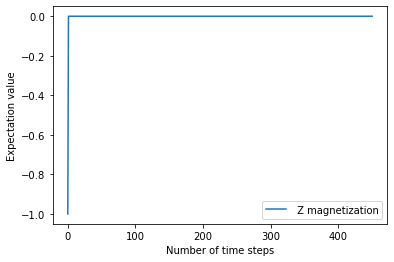

In [2]:
T = 2.5*2    # total time
N = 75*6      # Number of updates
dt = T/N       # time step

chi = 20              # Bond dimension
d = 2                                  # Dimension of physical index
h_x, h_y, h_z = np.sqrt(3) , np.log(2), 0.  # Field in the different directions
J_xx, J_yy, J_zz = 0.2, 0., 0.29  # Strength of spin interactions

Model = [[""],["x","y"]]     # The first part of the model gives us the spin interaction and the second one the fields
Interactions, Fields = Model_coefficients(J_xx,J_yy,J_zz,h_x,h_y,h_z)

# Initial antiferromagnetic product state
Gamma_0 = np.zeros((chi,d,chi)).astype(complex)
Gamma_0[0,0,0]=1.+0j
Gamma_0/=LA.norm(Gamma_0)

Gamma_1=np.zeros((chi,d,chi)).astype(complex)
Gamma_1[0,1,0]=1.+0j
Gamma_1/=LA.norm(Gamma_1)

Gamma=[Gamma_0,Gamma_1]

lama=np.zeros(chi)
lama[0]=1.
lam=[lama,lama]

# Hamiltonian
H  = Create_Hamiltonian(Model,S1,Interactions,Fields,d)

# Time evolution operator
U=expm(-1j*dt*H.reshape(d**2,-1)).reshape(d,d,d,d)
# 2 site wave funciotn

Mz_iTEBD = np.zeros(N+1).astype(data_type)
Mz_iTEBD[0] = Exp_value_two_site(lam[0],Gamma[0],lam[1],Gamma[1],S_z,S_z)

Entropy_iTEBD = np.zeros(N+1).astype(data_type)
Entropy_iTEBD[0] = Entropy(lam[0])

# Profile and Execute function
profiler = cProfile.Profile()
profiler.enable()

Compute_Theta(lam[0],Gamma[0],lam[1],Gamma[1])              # Main code

profiler.disable()
stats = pstats.Stats(profiler).sort_stats('tottime')
stats.print_stats()

#Plotting 
plt.plot(Mz_iTEBD.real,label=" Z magnetization")
plt.legend()
plt.xlabel("Number of time steps")
plt.ylabel("Expectation value")
plt.show()

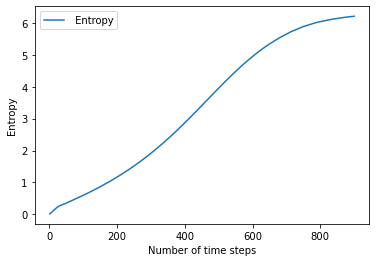

6.207868312534091


In [22]:
plt.plot(Entropy_iTEBD.real,label=" Entropy")
plt.legend()
plt.xlabel("Number of time steps")
plt.ylabel("Entropy")
plt.show()
print(Entropy(lam[0]))